In [1]:
%pip install icecream

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
print=ic

In [24]:
class FrameElement2D:
    def  __init__(self, node_indeces, node_coordinates,E,A,L,I, theta = 0):
        self.node_indeces = node_indeces
        self.node_coordinates = node_coordinates
        self.E = E
        self.A = A
        self.L = L
        self.I = I
        self.theta = theta
        self.k_elem_local = None

    def get_local_stiffness_matrix(self):
        # returns the stiffness matrix for the element in local coordinates
        E = self.E; I = self.I; L = self.L; A = self.A
        self.k_elem_local = np.array(
            [[E*A/L, 0,0,-E*A/L,0,0],
             [0, 12*E*I/L**3, 6*E*I/L**2, 0, -12*E*I/L**3, 6*E*I/L**2],
             [0, 6*E*I/L**2, 4*E*I/L, 0, -6*E*I/L**2, 2*E*I/L],
             [-E*A/L, 0,0,E*A/L,0,0],
             [0, -12*E*I/L**3, -6*E*I/L**2, 0, 12*E*I/L**3, -6*E*I/L**2],
             [0, 6*E*I/L**2, 2*E*I/L, 0, -6*E*I/L**2, 4*E*I/L]])
        return self.k_elem_local

    def get_global_stiffness_matrix(self):
        self.get_local_stiffness_matrix()
        # returns the global stiffness matrix for the element in global coordinates
        S = np.sin(np.deg2rad(self.theta))
        C = np.cos(np.deg2rad(self.theta))
        self.T = np.array([
            [C,S, 0,0,0,0],
            [-S,-C, 0,0,0,0],
            [0,0,1,0,0,0],
            [0,0,0,C,S,0],
            [0,0,0,-S,C,0],
            [0,0,0,0,0,1]])

        self.K_elem_global = self.T.T @ self.k_elem_local @ self.T
        return self.K_elem_global


In [25]:
class FrameSystem2D:
    def __init__(self, elements, num_nodes, forces, boundary_conditions):
        self.elements = elements
        self.num_nodes = num_nodes
        self.forces = forces
        self.boundary_conditions = boundary_conditions


In [110]:
class Solver:
    def __init__(self, system):
        self.system = system

    def solve(self):
        K_global, F_global = self.assemble_global_matrices()
        Kuu, Fu = self.apply_boundary_conditions()
        displacements = self.solve_displacements()
        # loads = self.calculate_internal_forces_and_moments()

        # return self.displacements, self.loads

    def assemble_global_matrices(self):
        # Assemble global stiffness
        self.K_global = np.zeros((self.system.num_nodes*3, self.system.num_nodes*3)) # multiply by 3 cause for a node 3 is the DoF

        for element in self.system.elements:
            K_elem = element.get_global_stiffness_matrix()
            node_per_element = len(self.system.elements[0].node_indeces) # 2 for linear

            # Get the global DOF indices for the element's nodes
            global_dof_indices = []
            for node_index in element.node_indeces:
                global_dof_indices.extend([2 * node_index, 2 * node_index + 1, 2 * node_index + 2])  # DOFs: x, y, z

            for i in range(len(global_dof_indices)):
                for j in range(len(global_dof_indices)):
                    self.K_global[global_dof_indices[i], global_dof_indices[j]] += K_elem[i, j]

        # Assemble load vector
        self.F_global = np.zeros((self.system.num_nodes*3))
        for node_index, f_x, f_y, m_z in self.system.forces:
            global_dof_index = int(3 * node_index)
            self.F_global[global_dof_index] += f_x
            self.F_global[global_dof_index + 1] += f_y
            self.F_global[global_dof_index + 2] += m_z

        return self.K_global, self.F_global

    def apply_boundary_conditions(self):
        known_global_indeces = []
        for node_index, constraint_x, constraint_y, constraint_theta in self.system.boundary_conditions:
            global_dof_index = int(3 * node_index)
            if constraint_x == 1:
                known_global_indeces.append(global_dof_index)
            if constraint_y == 1:
                known_global_indeces.append(global_dof_index + 1)
            if constraint_theta == 1:
                known_global_indeces.append(global_dof_index + 2)

        self.known_global_indeces = known_global_indeces
        self.unknown_global_indeces = [i for i in range(self.system.num_nodes*3) if i not in self.known_global_indeces]

        # get the matrix while remowing the indeces in known global indeces
        self.Kuu = np.delete(np.delete(self.K_global, known_global_indeces, axis=0), known_global_indeces, axis=1)
        self.Fu = np.delete(self.F_global, known_global_indeces, axis=0)

        return self.Kuu, self.Fu

    def solve_displacements(self):
        self.Du = np.linalg.solve(self.Kuu, self.Fu) # unknown displacements

        # merge known and unknown displacements based on self.known_global_indeces
        self.displacements = np.zeros((self.system.num_nodes*3))
        self.displacements[self.unknown_global_indeces] = self.Du

        return self.displacements

    def calculate_internal_forces_and_moments(self):
        self.internal_forces = np.zeros((len(self.system.elements), 2)) # V, M
        for i, element in enumerate(self.system.elements):
                d_e = self.displacements[ i*2: i*2+2*2] # displacement_element

                E = element.E, I = element.I

                V = -E*I* np.dot(element.get_d3N_dx3(), d_e)
                M1, M2 = -E*I*np.dot(element.get_d2N_dx2(), d_e)

                self.internal_forces[i] = [V, M1, M2]

        return self.internal_forces


In [155]:
class Plotter:
    def __init__(self, solver):
        self.system = solver.system
        self.displacements = solver.displacements
        # self.stresses = solver.stresses

    def plot_system(self):
        """
        plots the truss system
        """
        for i, element in enumerate(self.system.elements):
            pos1, pos2 = element.node_coordinates
            node_index1, node_index2 = element.node_indeces
            offset = +0 # for text

            # PLOT INITIAL SYSTEM
            x1, y1 = pos1
            x2, y2 = pos2
            plt.scatter([x1,x2], [y1,y2],c="r")
            plt.plot([x1,x2], [y1,y2],c="r")
            plt.text(x1, y1+offset, node_index1, color="r", horizontalalignment='left',
        verticalalignment='top')
            plt.text(x2, y2+offset, node_index2, color="r", horizontalalignment='left',
        verticalalignment='top')


            # PLOT SYSTEM WITH DISPLACEMENTS
            dx1, dy1, dtheta1 = self.displacements[3*node_index1:3*node_index1+3]
            dx2, dy2, dtheta2 = self.displacements[3*node_index2:3*node_index2+3]

            print(dx1, dy1, dtheta1, dx2, dy2, dtheta2)

            x1_disp = x1 + dx1; y1_disp = y1 + dy1
            x2_disp = x2 + dx2; y2_disp = y2 + dy2

            plt.scatter([x1_disp,x2_disp], [y1_disp,y2_disp],c="b")
            plt.plot([x1_disp,x2_disp], [y1_disp,y2_disp],c="b", linestyle="--")
            plt.text(x1_disp, y1_disp+offset, node_index1, color="b", horizontalalignment='left',
        verticalalignment='top')
            plt.text(x2_disp, y2_disp+offset, node_index2, color="b", horizontalalignment='left',
        verticalalignment='top')


            # # PLOT ELEMENT INTERNAL FORCES
            # x_mid = x1_disp + (x2_disp - x1_disp) * 0.5
            # y_mid = y1_disp + (y2_disp - y1_disp) * 0.5
            # plt.text(x_mid, y_mid, f"{self.stresses[i]/1000*element.A:.2f} kN", color="black")


        plt.title("Frame Element(s)")
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.show()

In [156]:
# [units: N, mm, MPa]
E = 200e3; I = 7.81E7; L=6e3; A = 625
P = 2000e3 # applied force

connectivity = np.array([[0,1], [1,2], [2,3]])
nodal_coordinates = np.array([[0,0], [0,L], [L,L], [L,0]])
angles_of_elements = np.array([90, 0, 90])

# node_index, constraint_x, constraint_y, constraint_theta
boundary_conditions = np.array([
                            [0,1,1,1],
                            [3,1,1,1]])

 # node_index, f_x, f_y, moment_z
forces = np.array([
                [1, P, 0, 0],   # applied force
                ])

num_nodes = (np.max(connectivity) + 1)

elements = []
for i, node_indeces in enumerate(connectivity):
    node_coordinates = nodal_coordinates[node_indeces]
    L_element = L
    element = FrameElement2D(node_indeces, node_coordinates, E,A,L_element,I, theta = angles_of_elements[i])
    elements.append(element)

system = FrameSystem2D(elements, num_nodes, forces, boundary_conditions)


In [157]:
solver = Solver(system)
K_global, F_global = solver.assemble_global_matrices()
Kuu, Fu = solver.apply_boundary_conditions()

_ = print(Kuu.shape, Fu.shape)
_ = print(Kuu, Fu)


ic| Kuu.shape: (6, 6), Fu.shape: (6,)
ic| Kuu: array([[ 2.17011111e+04, -2.60333333e+06,  8.67777778e+02,
                 -2.60333333e+06,  0.00000000e+00,  0.00000000e+00],
                [-2.60333333e+06,  2.08266884e+10, -2.60333333e+06,
                  5.20406247e+09, -1.22253769e-12, -2.60333333e+06],
                [ 8.67777778e+02, -2.60333333e+06,  2.17011111e+04,
                 -2.60333333e+06, -2.08333333e+04, -1.59408192e-10],
                [-2.60333333e+06,  5.20406247e+09, -2.60333333e+06,
                  2.08318742e+10, -1.58185654e-10,  5.20927000e+09],
                [ 0.00000000e+00, -1.22253769e-12, -2.08333333e+04,
                 -1.58185654e-10,  2.08333333e+04, -1.59408192e-10],
                [ 0.00000000e+00, -2.60333333e+06, -1.59408192e-10,
                  5.20927000e+09, -1.59408192e-10,  1.04133333e+10]])
    Fu: array([2000000.,       0.,       0.,       0.,       0.,       0.])


In [158]:
solver = Solver(system)
solver.solve()
# _ = print(solver.K_global, solver.F_global, solver.Kuu, solver.Fu, solver.Du, solver.displacements)

for i in range(0, len(solver.displacements), 3):
    nodal_disp = f"Node {i//3+1}: del_x = {solver.displacements[i]:.4f} mm, del_y = {solver.displacements[i+1]:.4f} mm, del_theta = {solver.displacements[i+2]:.4f} rad"
    print(nodal_disp)

ic| nodal_disp: 'Node 1: del_x = 0.0000 mm, del_y = 0.0000 mm, del_theta = 0.0000 rad'
ic| nodal_disp: 'Node 2: del_x = 96.0000 mm, del_y = 0.0000 mm, del_theta = -96.0000 rad'
ic| nodal_disp: 'Node 3: del_x = 0.0000 mm, del_y = -96.0000 mm, del_theta = -0.0000 rad'
ic| nodal_disp: 'Node 4: del_x = 0.0000 mm, del_y = 0.0000 mm, del_theta = 0.0000 rad'


ic| dx1: 0.0
    dy1: 0.0
    dtheta1: 0.0
    dx2: 95.99999999999997
    dy2: 6.569799378530046e-17
    dtheta2: -95.99999999999929
ic| dx1: 95.99999999999997
    dy1: 6.569799378530046e-17
    dtheta1: -95.99999999999929
    dx2: 7.883982359016063e-17
    dy2: -95.99999999999929
    dtheta2: -4.236234957048515e-17
ic| dx1: 7.883982359016063e-17
    dy1: -95.99999999999929
    dtheta1: -4.236234957048515e-17
    dx2: 0.0
    dy2: 0.0
    dtheta2: 0.0


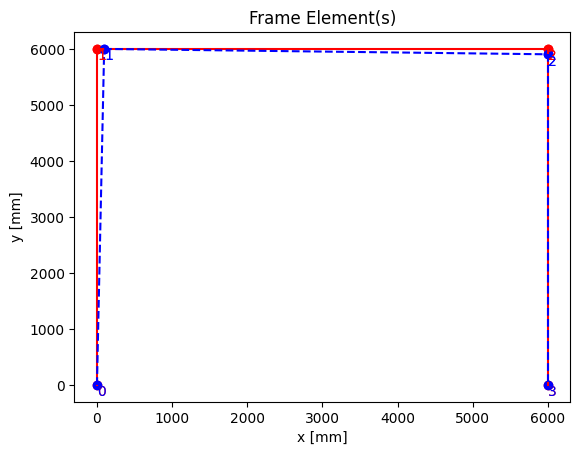

In [159]:
plotter = Plotter(solver)
plotter.plot_system()